In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import pulp
import random
import time

## User Input


In [20]:
# print("Do you want personalized planning by providing some information like Height weight, etc.?")
print("If YES, Press X = 1, Otherwise X = 0")

x = int(input("X = "))

If YES, Press X = 1, Otherwise X = 0


X =  1


## Calculating BMR and Nutrients Constraints

In [21]:
#BMR calculation 
def calculate_bmr(gender, weight, height, age):
    if gender.lower() == 'male':
        return (10 * weight) + (6.25 * height) - (5 * age) + 5
    else:
        return (10 * weight) + (6.25 * height) - (5 * age) - 161

if(x==1):
    
    # user = {
    # 'name': 'Jamiya Alom',
    # 'age': 20,
    # 'gender': 'female',
    # 'height': 190,  # in cm
    # 'weight': 75,   # in kg
    # }

    user = {}

    # user input
    user['name'] = input("Enter your name: ")
    user['age'] = int(input("Enter your age: "))
    user['gender'] = input("Enter your gender (male/female): ").lower()
    user['height'] = float(input("Enter your height in cm: "))
    user['weight'] = float(input("Enter your weight in kg: "))

    bmr1= calculate_bmr(user['gender'], user['weight'], user['height'], user['age'])
    print(f"Calculated BMR: {bmr1:.2f} kcal")

    min_cal= bmr1 * 1.2
    max_cal = bmr1 * 1.9

    # Minimum Calory needed
    bmr= bmr1*1.2

    # Protein Calculation
    Pconst = (bmr*0.20)/4

    # Fat Calculation
    Fconst = (bmr * 0.25)/9

    #Sugar Calculation
    Sconst = (bmr * 0.12)/4

    Sodium_const = 2500

    print(f"Minimum Calory: {bmr:.2f}, min_cal: {min_cal}, max_cal: {max_cal}, min Protein: {Pconst}, max_fat: {Fconst}, max_sugar: {Sconst}, max_sodium:{Sodium_const}")
    
else:
    min_cal = 2200
    max_cal = 3500
    Pconst = 110
    Fconst = 61
    Sconst = 66
    Sodium_const = 2500
    print(f"min_cal: {min_cal}, max_cal: {max_cal}, min Protein: {Pconst}, max_fat: {Fconst}, max_sugar: {Sconst}, max_sodium:{Sodium_const}")

Enter your name:  K
Enter your age:  29
Enter your gender (male/female):  male
Enter your height in cm:  180
Enter your weight in kg:  82


Calculated BMR: 1805.00 kcal
Minimum Calory: 2166.00, min_cal: 2166.0, max_cal: 3429.5, min Protein: 108.30000000000001, max_fat: 60.166666666666664, max_sugar: 64.98, max_sodium:2500


## Data Loading


In [22]:
print("\nLoading food data...")
data = pd.read_csv("../dataset/7_11_food_choices.csv")
data


Loading food data...


,ITEM,Calories(kCal),Sugar(g),Protein(g),Fat(g),Sodium(mg),Price(baht)
0,Ham Cheese Sandwich,230.0,3.0,9.0,11.0,202.7,32
1,Salmon Onigiri,194.0,0.0,6.9,2.7,54.0,27
2,Tuna Cheese Toast Sandwich,310.0,5.0,11.0,20.0,154.0,32
3,Shredded Pork with salad\nCream Sandwich,260.0,12.0,8.0,13.0,230.0,32
4,Carbonara Danish Sandwich,390.0,4.0,8.0,26.0,6.0,32
...,...,...,...,...,...,...,...
91,Watermelon,30.0,6.0,0.6,0.2,1.0,20
92,Grapefruits,42.0,7.0,0.8,0.1,0.0,40
93,Passon Fruit,97.0,11.0,2.2,0.7,28.0,30
94,Kiwi,60.0,9.0,1.1,0.5,3.0,40


### data extraction


In [23]:
# Extracting the data and convert it to the list
prices = data['Price(baht)'].tolist()
calories = data['Calories(kCal)'].tolist()
proteins = data['Protein(g)'].tolist()
fats = data['Fat(g)'].tolist()
sugars = data['Sugar(g)'].tolist()
sodium = data['Sodium(mg)'].tolist()
items = data['ITEM'].tolist()

# Number of food items
n = len(items)
min_item = 3
max_item = 10

max_possible_price = sum(sorted(prices, reverse=True)[:max_item])
max_possible_protein = sum(sorted(proteins, reverse=True)[:max_item])

## Weight-sum Methods with Genetic Algorithm

In [27]:
# --- define Weights between 0.0 - 1.0"
print("Define Weights between 0.0 - 1.0 [lower weight means it has less importance in the overall calculation]")
w1 = float(input("Enter weight for minimizing cost (w1): "))
w2 = float(input("Enter weight for maximizing protein (w2): "))

POPULATION_SIZE = 100
GENERATIONS = 300
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.1
ELITE_COUNT = 5

def create_chromosome():
    for _ in range(1000):
        chromosome = [1 if random.random() < 0.1 else 0 for _ in range(n)]
        if min_item <= sum(chromosome) <= max_item:
            return chromosome
    chromosome = [0] * n
    selected_indices = random.sample(range(n), min_item)
    for idx in selected_indices:
        chromosome[idx] = 1
    return chromosome


def fitness(chromosome, w1, w2):
    total_price = total_protein = total_calories = 0
    total_fat = total_sugar = total_sodium = item_count = 0

    for i in range(n):
        if chromosome[i]:
            total_price += prices[i]
            total_protein += proteins[i]
            total_calories += calories[i]
            total_fat += fats[i]
            total_sugar += sugars[i]
            total_sodium += sodium[i]
            item_count += 1

    # Apply constraints as penalty
    penalty = 0
    if item_count < min_item or item_count > max_item:
        penalty += 100
    if total_calories < min_cal or total_calories > max_cal:
        penalty += 100
    if total_fat > Fconst:
        penalty += 100
    if total_sugar > Sconst:
        penalty += 100
    if total_sodium > Sodium_const:
        penalty += 100

    # Normalize cost and protein to [0, 1]
    normalized_cost = total_price / max_possible_price if max_possible_price else 0
    normalized_protein = total_protein / max_possible_protein if max_possible_protein else 0

    # Multi-objective: minimize cost, maximize protein
    score = (w1 * normalized_cost) - (w2 * normalized_protein)

    return score + penalty


def select(population):
    candidates = random.sample(population, 3)
    return min(candidates, key=lambda c: fitness(c, w1, w2))


def crossover(parent1, parent2):
    if random.random() < CROSSOVER_RATE:
        point = random.randint(1, n - 2)
        child1 = fix_chromosome(parent1[:point] + parent2[point:])
        child2 = fix_chromosome(parent2[:point] + parent1[point:])
        return [child1, child2]
    return [parent1[:], parent2[:]]

def mutate(chromosome):
    for i in range(n):
        if random.random() < MUTATION_RATE:
            chromosome[i] = 1 - chromosome[i]
    return fix_chromosome(chromosome)

def fix_chromosome(chromosome):
    while sum(chromosome) < min_item:
        index = random.randint(0, n - 1)
        chromosome[index] = 1
    while sum(chromosome) > max_item:
        ones = [i for i in range(n) if chromosome[i] == 1]
        chromosome[random.choice(ones)] = 0
    return chromosome


Define Weights between 0.0 - 1.0 [lower weight means it has less importance in the overall calculation]


Enter weight for minimizing cost (w1):  0.4
Enter weight for maximizing protein (w2):  0.6


## Main Function


In [28]:

NUM_RUNS = 13

all_execution_times = []
run_costs = []
run_proteins = []

all_best_fitness = []  # store best fitness per generation for each run
all_avg_fitness = []   # store average fitness per generation for each run


best_costs = []
avg_costs = []
best_proteins = []
avg_proteins = []

for run in range(NUM_RUNS):
    print(f"\n=== GA Run {run + 1} ===")
    start_time = time.time()
    print("\nRunning Genetic Algorithm...")

    population = [create_chromosome() for _ in range(POPULATION_SIZE)]

    best_fitness_per_gen = []
    avg_fitness_per_gen = []

    for generation in range(GENERATIONS):
        # Sort population by fitness (lower is better)
        population = sorted(population, key=lambda c: fitness(c, w1, w2))

        # Record best and average fitness
        fitness_values = [fitness(c, w1, w2) for c in population]
        best_fitness_per_gen.append(min(fitness_values))
        avg_fitness_per_gen.append(sum(fitness_values) / len(fitness_values))

        # Keep elites
        new_population = population[:ELITE_COUNT]

        # Generate the rest of population
        while len(new_population) < POPULATION_SIZE:
            parent1 = select(population)
            parent2 = select(population)
            offspring = crossover(parent1, parent2)
            for child in offspring:
                new_population.append(mutate(child))
                if len(new_population) >= POPULATION_SIZE:
                    break

        population = new_population

    # Store fitness data from this run
    all_best_fitness.append(best_fitness_per_gen)
    all_avg_fitness.append(avg_fitness_per_gen)

    # Best chromosome from the final generation
    best_chromosome = min(population, key=lambda c: fitness(c, w1, w2))

    total_cost = total_calories = total_protein = total_fat = total_sugar = total_sodium = 0

    costs = []
    proteins_list = []

    print("\nBest Daily Meal Plan:")
    for i in range(n):
        if best_chromosome[i]:
            print(f" - {items[i]} | {calories[i]} Kcal | Price: {prices[i]} Baht| Protein: {proteins[i]} g | Fat: {fats[i]} g | Sugar: {sugars[i]} g")
            total_cost += prices[i]
            total_calories += calories[i]
            total_protein += proteins[i]
            total_fat += fats[i]
            total_sugar += sugars[i]
            total_sodium += sodium[i]

    print("\nSummary of Best Meal Plan:")
    print(f"Total Cost: {total_cost:.2f} Baht")
    print(f"Total Calories: {total_calories:.2f} Kcal")
    print(f"Total Protein: {total_protein:.2f} g")
    print(f"Total Fat: {total_fat:.2f} g")
    print(f"Total Sugar: {total_sugar:.2f} g")
    print(f"Total Sodium: {total_sodium:.2f} mg")

     # Nutritional Comparison Table
    comparison_table = [
            ["Calories (kcal)", f"{total_calories:.2f}", f"{min_cal:.0f}–{max_cal:.0f}"],
            ["Protein (g)", f"{total_protein:.2f}", f"≥ {Pconst:.0f}"],
            ["Fat (g)", f"{total_fat:.2f}", f"≤ {Fconst:.0f}"],
            ["Sugar (g)", f"{total_sugar:.2f}", f"≤ {Sconst:.0f}"],
            ["Sodium (mg)", f"{total_sodium:.2f}", f"≤ {Sodium_const:.0f}"],
        ]

    print("\n Nutritional Comparison:")
    print(tabulate(comparison_table, headers=["Nutrient", "Total in Plan", "Constraint"], tablefmt="pretty"))

    # (You can keep your requirement checks here as is...)

    all_execution_times.append(time.time() - start_time)
    run_costs.append(total_cost)
    run_proteins.append(total_protein)
    best_costs.append(total_cost)
    best_proteins.append(total_protein)

    final_gen_chromosomes = population
    for chrom in final_gen_chromosomes:
        cost = sum([prices[i] for i in range(n) if chrom[i]])
        protein = sum([proteins[i] for i in range(n) if chrom[i]])
        
        costs.append(cost)
        proteins_list.append(protein)

    avg_costs.append(np.mean(costs))
    avg_proteins.append(np.mean(proteins_list))


# Convert to numpy arrays for easier analysis
all_best_fitness = np.array(all_best_fitness)
all_avg_fitness = np.array(all_avg_fitness)

mean_best_fitness = np.mean(all_best_fitness, axis=0)
mean_avg_fitness = np.mean(all_avg_fitness, axis=0)
std_best_fitness = np.std(all_best_fitness, axis=0)
std_avg_fitness = np.std(all_avg_fitness, axis=0)



=== GA Run 1 ===

Running Genetic Algorithm...

Best Daily Meal Plan:
 - Ezygo Grilled Pork  with Sticky | 260.0 Kcal | Price: 35 Baht| Protein: 12.0 g | Fat: 4.5 g | Sugar: 3.0 g
 - Tuna Sandwich | 340.0 Kcal | Price: 30 Baht| Protein: 36.2 g | Fat: 10.4 g | Sugar: 2.0 g
 - Ezygo Stir-Fried Pork and Basil with Rice | 460.0 Kcal | Price: 35 Baht| Protein: 17.0 g | Fat: 12.0 g | Sugar: 2.0 g
 - Ezygo Salt Grilled  Pork with Japanese Rice | 440.0 Kcal | Price: 40 Baht| Protein: 16.0 g | Fat: 12.0 g | Sugar: 2.0 g
 - Ezygo Omelette with Rice | 340.0 Kcal | Price: 30 Baht| Protein: 13.0 g | Fat: 8.0 g | Sugar: 1.0 g
 - Chicken  Breast | 120.0 Kcal | Price: 40 Baht| Protein: 22.5 g | Fat: 2.6 g | Sugar: 0.0 g
 - Natural  Yogurt | 84.0 Kcal | Price: 20 Baht| Protein: 14.0 g | Fat: 0.0 g | Sugar: 4.0 g
 - Spicy Minced  Catfish Salad | 166.0 Kcal | Price: 50 Baht| Protein: 13.0 g | Fat: 10.0 g | Sugar: 2.0 g
 - Oishi Green Tea Yuzu Orange Flavor | 180.0 Kcal | Price: 16 Baht| Protein: 0.0 g |

## Plotting


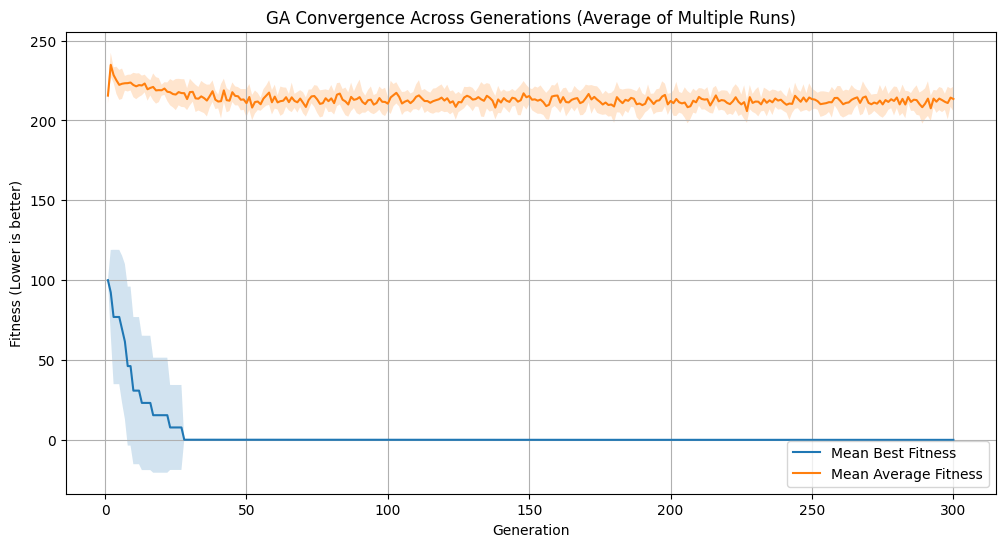

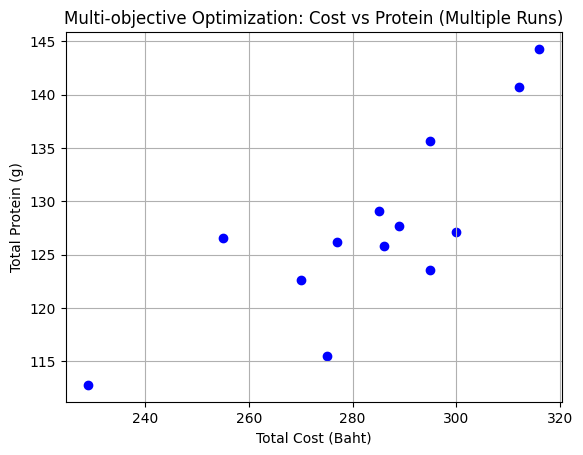

In [29]:
# Plotting generation-wise fitness convergence
plt.figure(figsize=(12, 6))
plt.plot(range(1, GENERATIONS+1), mean_best_fitness, label='Mean Best Fitness')
plt.fill_between(range(1, GENERATIONS+1),
                 mean_best_fitness - std_best_fitness,
                 mean_best_fitness + std_best_fitness,
                 alpha=0.2)

plt.plot(range(1, GENERATIONS+1), mean_avg_fitness, label='Mean Average Fitness')
plt.fill_between(range(1, GENERATIONS+1),
                 mean_avg_fitness - std_avg_fitness,
                 mean_avg_fitness + std_avg_fitness,
                 alpha=0.2)

plt.xlabel("Generation")
plt.ylabel("Fitness (Lower is better)")
plt.title("GA Convergence Across Generations (Average of Multiple Runs)")
plt.legend()
plt.grid(True)
plt.show()

# Your existing scatter plot for Cost vs Protein
plt.scatter(run_costs, run_proteins, color='blue')
plt.xlabel("Total Cost (Baht)")
plt.ylabel("Total Protein (g)")
plt.title("Multi-objective Optimization: Cost vs Protein (Multiple Runs)")
plt.grid(True)
plt.show()

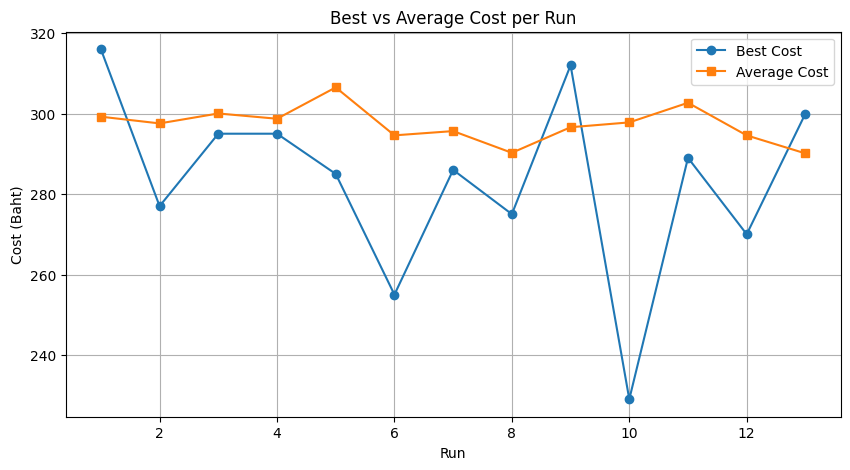

In [30]:
# Plotting Best & Average Cost Across Runs
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_RUNS+1), best_costs, label="Best Cost", marker='o')
plt.plot(range(1, NUM_RUNS+1), avg_costs, label="Average Cost", marker='s')
plt.xlabel("Run")
plt.ylabel("Cost (Baht)")
plt.title("Best vs Average Cost per Run")
plt.legend()
plt.grid(True)
plt.show()

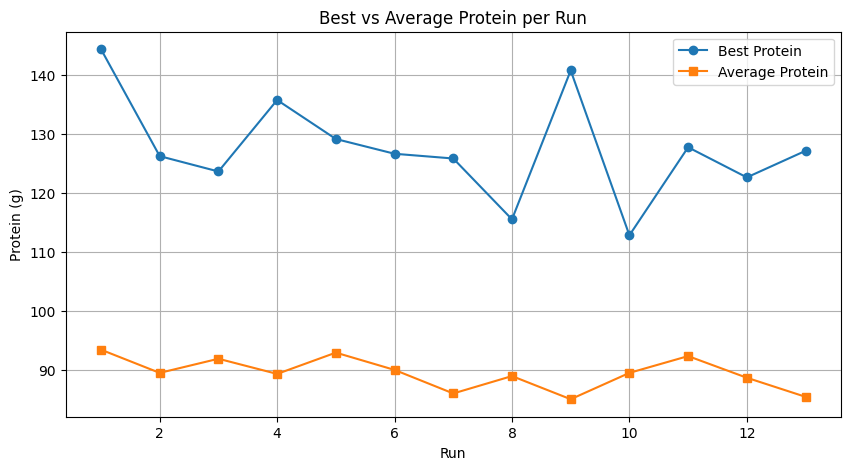

In [31]:
# Plotting Best & Average Protein Across Runs
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_RUNS+1), best_proteins, label="Best Protein", marker='o')
plt.plot(range(1, NUM_RUNS+1), avg_proteins, label="Average Protein", marker='s')
plt.xlabel("Run")
plt.ylabel("Protein (g)")
plt.title("Best vs Average Protein per Run")
plt.legend()
plt.grid(True)
plt.show()